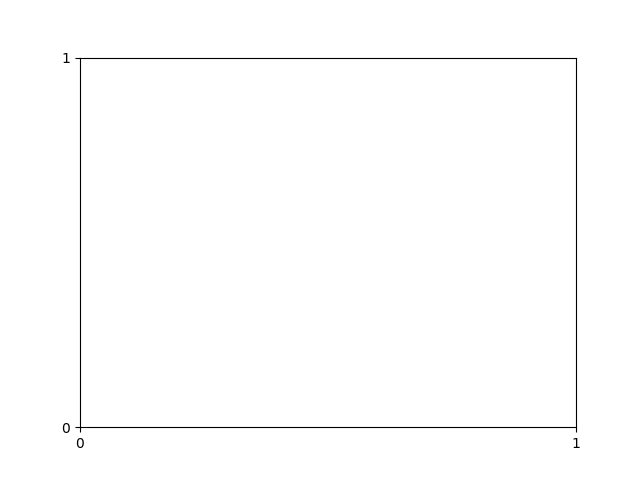

In [1]:
%matplotlib widget

PORT = '/dev/ttyACM1'
BAUD = 115200

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from importlib import reload # for debugging

import glitch_utils
from glitch_utils import GlitchResult
glitch_utils = reload(glitch_utils)

try:
	del glitcher
	del gc
except:
	pass
glitcher = glitch_utils.GlitchyMcGlitchFace(PORT, BAUD)
gc = glitch_utils.GlitchController(groups=[r.name for r in GlitchResult], parameters=['ext_offset', 'width'])
gc.set_range('ext_offset', 1337, 1339)
gc.set_range('width', 16, 17)

# NOTE This figure must be generated in a different cell than the one that calls the plot function
#	   Otherwise the plot will not be displayed until the cell is done executing (no live plot)
fig, ax = plt.subplots()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

In [2]:
for glitch_setting in gc.rand_glitch_values():
	read_result, read_data = glitcher.glitch_mul(glitch_setting, expected=0x1337)
	gc.add_result(glitch_setting, read_result)
	if read_result == GlitchResult.WEIRD:
		print('Got weird data:', read_data)
	ax.plot(*glitch_setting, glitch_utils.result_to_marker(read_result))
	fig.canvas.draw() # Guarantees live update of the plot whenever a new point is added